In [1]:
sys.path.append('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/skin-lesion-segmentation-transformer')
from Datasets.create_dataset import SkinClasDataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# loading data
loaders = {}
for dataset_name in ['isic2018','PH2','DMF','SKD']:
    dataset = SkinClasDataset(dataset_name, 256)
    loaders[dataset_name] = torch.utils.data.DataLoader(dataset,
                                                batch_size=16,
                                                shuffle=False,
                                                num_workers=2,
                                                pin_memory=True,
                                                drop_last=False)

In [3]:
model_name = 'FATNet_KT_adapt'
exp_name = 'N69'
if model_name == 'FATNet_adapt':
    from Models.Transformer.UFAT_for_adapt_vis import FATNet_adapt
    network = FATNet_adapt(img_size=256, drop_rate=0.1, drop_path_rate=0.1,
        conv_norm=torch.nn.BatchNorm2d, adapt_method='Sup', num_domains=4, 
        feature_dim=512, do_detach=False)
    network.load_state_dict(torch.load('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/results/'+
    'N_results/{}/ca_SupDo_fold4_FATNet_adapt_20221208_1858/best.pth'.format(exp_name))) 
elif model_name == 'FATNet_KT_adapt':
    from Models.Transformer.UFAT_for_adapt_vis import FATNet_KT_adapt
    network = FATNet_KT_adapt(img_size=256, drop_rate=0.1, drop_path_rate=0.1,
    conv_norm=torch.nn.BatchNorm2d, adapt_method='Sup', num_domains=4, do_detach=False, decoder_name='MLPFM')
    network.load_state_dict(torch.load('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/results/'+
    'N_results/{}/ca_4detKT_nodetachMLPFM_SupDo_fold_FATNet_KT_adapt_20230101_1241/best.pth'.format(exp_name)))
network.cuda()

FATNet_KT_adapt(
  (stem): Sequential(
    (0): Conv2d_BN(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_layer): Hardswish()
    )
    (1): Conv2d_BN(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_layer): Hardswish()
    )
  )
  (patch_embed_stages): ModuleList(
    (0): DWCPatchEmbed(
      (patch_conv): DWConv2d_BN(
        (dwconv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pwconv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Hardswish()
      )
    )
    (1): DWCPatchEmbed(
      (patch_conv): DWConv2d_BN(
    

In [4]:
domain_att_perdataset = {}
for dataset_name in ['isic2018','PH2','DMF','SKD']:
    loader = loaders[dataset_name]
    features = []
    diagnosis_list = []
    d_label_list = []
    dataset_id_list = []
    DC_id_list = []
    domain_att_list = []
    for batch in tqdm(loader):
        # img = batch['image'].cuda().float()
        img = batch['image'].float().cuda()
        diagnosis = batch['diagnosis_id']
        dataset_id = batch['set_id']
        DC_id = batch['DC_id']
        with torch.no_grad():
            # resnet
            if model_name == 'resnet':
                output = network(img)
                output = output.view(output.size(0), -1).cpu().numpy()
            # coat
            elif model_name == 'coat':
                output = network.forward_features(img)
                output = output[:,0].cpu().numpy()
            elif model_name == 'FATNet':
                output = network(img,out_feat=True,out_seg=False)
                output = output['feat'].cpu().numpy()
            elif model_name == 'FATNet_adapt':
                domain_label = batch['set_id']
                # domain_label_oh = torch.nn.functional.one_hot(domain_label, 4).float().cuda()
                domain_label_oh = torch.nn.functional.one_hot(domain_label, 4).float()
                output = network(img,domain_label_oh,out_feat=True,out_seg=False)
                # output = output['feat'].cpu().numpy()
                domain_att = output['domain_att'].cpu().numpy()
                # print(domain_att.shape)
                four_id = batch['four_id'].cpu().numpy()
            elif model_name == 'FATNet_dynamic':
                four_id = batch['four_id'].cpu().numpy()
                d_label = dynamic_np[four_id,0].astype('int64')
                d_label_oh = torch.nn.functional.one_hot(torch.from_numpy(d_label),4).float().cuda()
                output = network(img,d_label_oh,out_feat=True,out_seg=False)
                output = output['feat'].cpu().numpy()
                d_label_list.extend(d_label)
            elif model_name == 'FATNet_KT_adapt':
                domain_label = batch['set_id']
                domain_label_oh = torch.nn.functional.one_hot(domain_label, 4).float().cuda()
                output = network(img,domain_label_oh,out_feat=True,out_seg=False)
                # output = output['feat'].cpu().numpy()
                domain_att = output['domain_att'].cpu().numpy()
            # print(output.shape)
            # print(d_label_list)
            # features.append(output)
            # diagnosis_list.extend(diagnosis)
            # dataset_id_list.extend(dataset_id)
            # DC_id_list.extend(DC_id)
            domain_att_list.append(domain_att)
    domain_att_arr = np.concatenate(domain_att_list, axis=0)
    domain_att_arr = domain_att_arr.squeeze()
    domain_att_arr = np.average(domain_att_arr, axis=0)
    domain_att_perdataset[dataset_name] = domain_att_arr


100%|██████████| 13/13 [00:01<00:00, 11.32it/s]


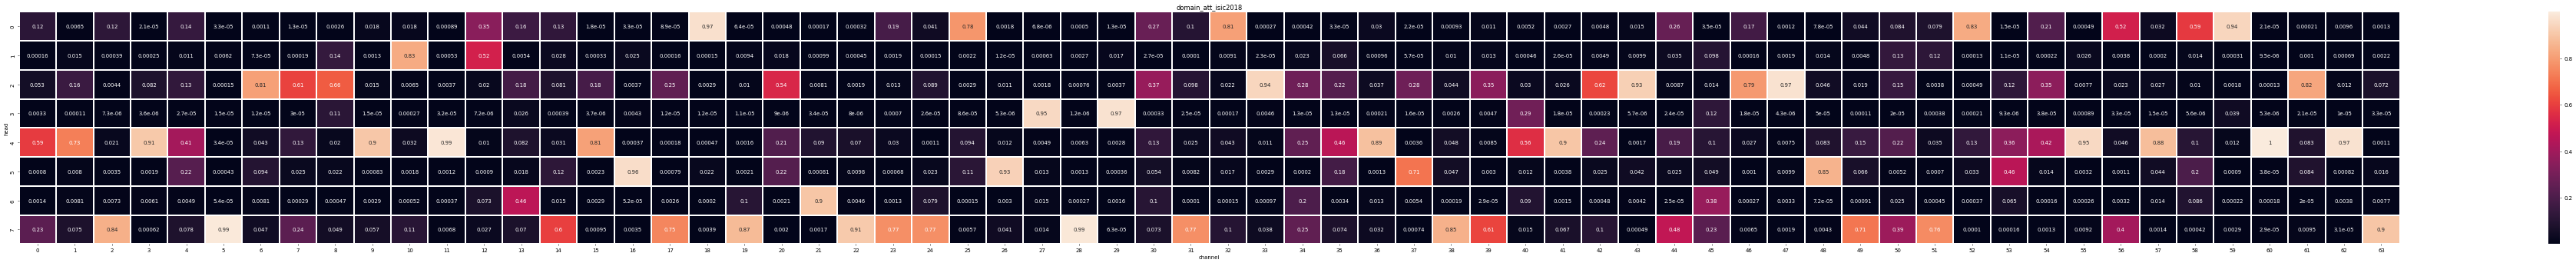

In [5]:
dataset_name = 'isic2018'
plt.figure(figsize=(100,8), dpi=50)
sns.heatmap(domain_att_perdataset[dataset_name], annot=True, fmt=".2g", linewidths=.5)
plt.xlabel('channel')
plt.ylabel('head')
name = 'domain_att_{}'.format(dataset_name)
plt.title(name)
plt.show()

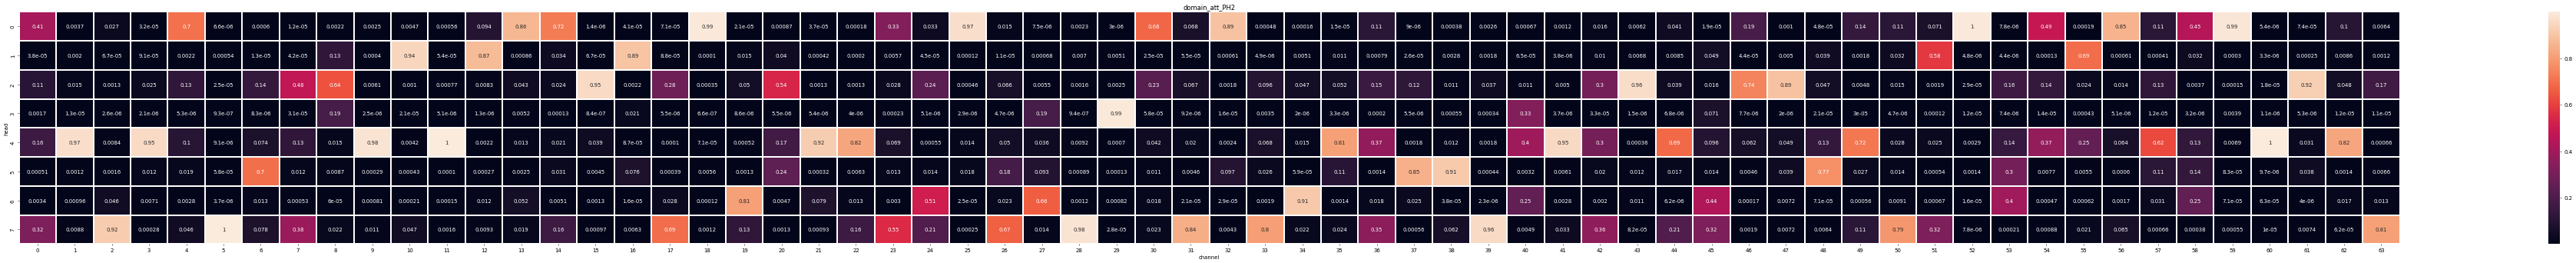

In [6]:
dataset_name = 'PH2'
plt.figure(figsize=(100,8), dpi=50)
sns.heatmap(domain_att_perdataset[dataset_name], annot=True, fmt=".2g", linewidths=.5)
plt.xlabel('channel')
plt.ylabel('head')
name = 'domain_att_{}'.format(dataset_name)
plt.title(name)
plt.show()

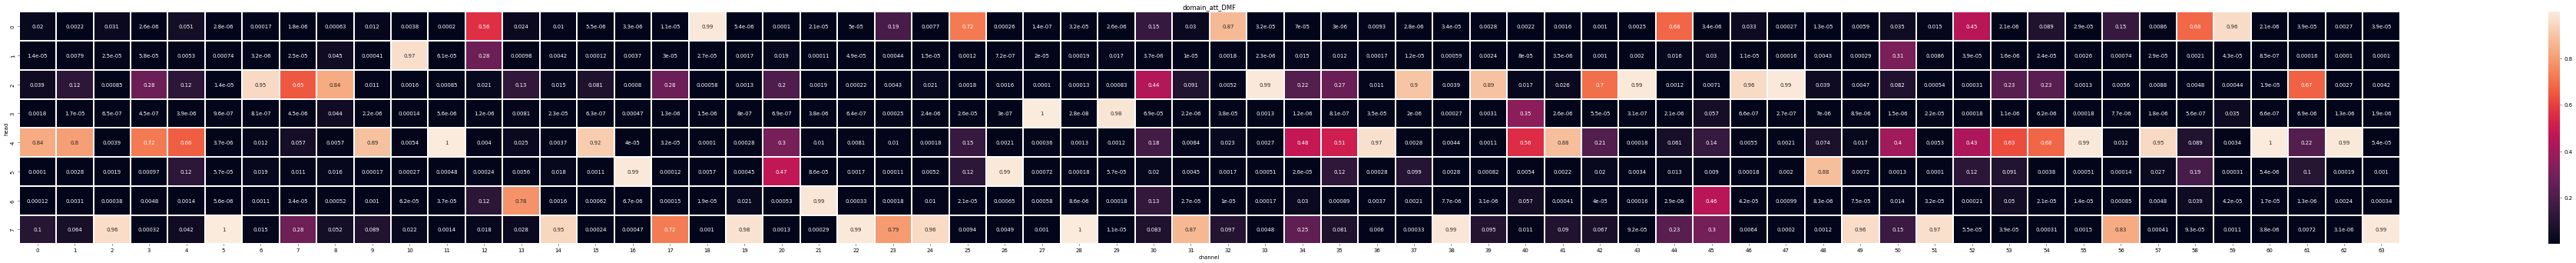

In [7]:
dataset_name = 'DMF'
plt.figure(figsize=(100,8), dpi=50)
sns.heatmap(domain_att_perdataset[dataset_name], annot=True, fmt=".2g", linewidths=.5)
plt.xlabel('channel')
plt.ylabel('head')
name = 'domain_att_{}'.format(dataset_name)
plt.title(name)
plt.show()

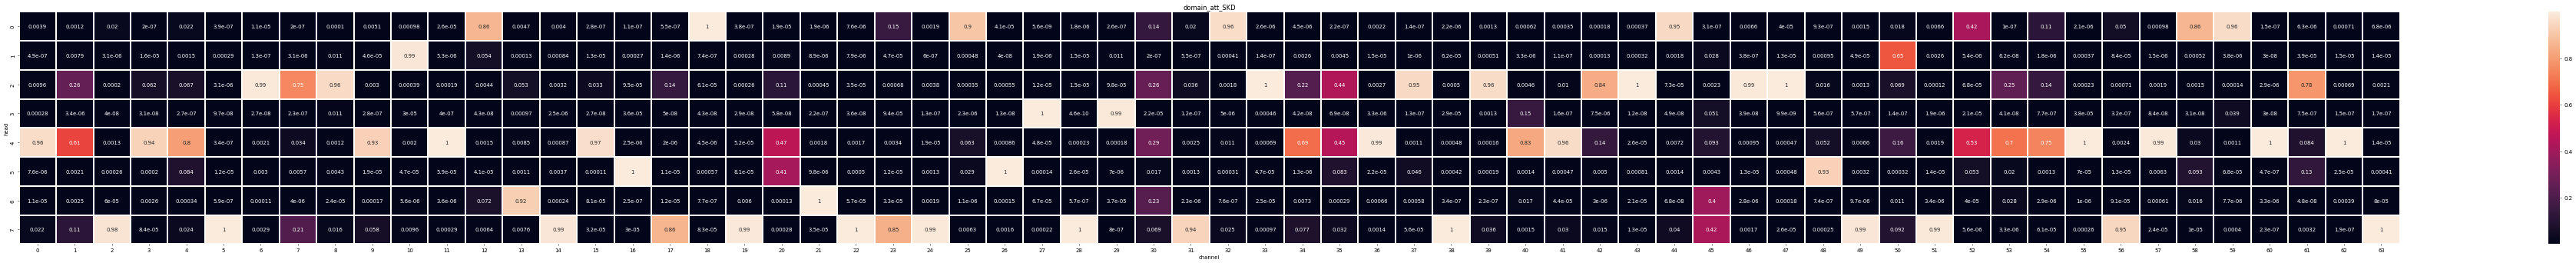

In [8]:
dataset_name = 'SKD'
plt.figure(figsize=(100,8), dpi=50)
sns.heatmap(domain_att_perdataset[dataset_name], annot=True, fmt=".2g", linewidths=.5)
plt.xlabel('channel')
plt.ylabel('head')
name = 'domain_att_{}'.format(dataset_name)
plt.title(name)
plt.show()